# Notes on Digital Signal Processing And Statistics
by Gonzalo Sánchez Pla

## Resources:

### Books:

<ul>
<li><a href="https://www.packtpub.com/big-data-and-business-intelligence/building-machine-learning-systems-python">Building Machine Learning Systems With Python</a>, by Willi Richert and Luis Pedro Coelho</li>
<li><a href="http://www.apress.com/9781484205549">Numerical Python A Practical Techniques Approach for Industry</a>, by Robert Johansson</li>
</ul>


### Sites:

<ul>
<li><a href="http://opihi.cs.uvic.ca/sound/genres.tar.gz">http://opihi.cs.uvic.ca/sound/genres.tar.gz</a></li>
<li><a href="http://stackoverflow.com/">http://stackoverflow.com/</a></li>
<li><a href="http://sox.sourceforge.net/">http://sox.sourceforge.net</a></li>
<li><a href="http://www.dspguide.com/pdfbook.htm">The Scientist and Engineer's Guide to Digital Signal Processing</a>, by Steven W. Smith, Ph.D</li>
<li><a href="http://nbviewer.jupyter.org/github/unpingco/Python-for-Signal-Processing/tree/master/">http://nbviewer.jupyter.org/github/unpingco/Python-for-Signal-Processing/tree/master/</a></li>
<li><a href="https://searchcode.com/codesearch/view/92230506/">https://searchcode.com/codesearch/view/92230506/</a></li>
<li><a href="http://www.scales-chords.com/">http://www.scales-chords.com/</a></li>
</ul>

##### Notice:
If you are not able to display correctly this page, try this <a href="https://nbviewer.jupyter.org/github/gonzsanc/computer_vision_digital_signal/blob/master/Music%20Classification.ipynb">Alternative Notebook</a>
    


## Part I - Introduction

In [140]:
import numpy as np
import scipy
from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
from scipy import fftpack
import pandas as pd
from pandas import DataFrame

Name of metal location:<br/>
metal.00001.wav - metal.00099.wav

In [3]:
musicMetalPath = "/Descargas/Music_Genres/genres/metal/"
GENRE_DIR = "/Descargas/Music_Genres/genres/"

Loading sample rate and samples from WAV file:

In [72]:
sample_rate, X = wavfile.read("./wavSamples/LYNCWH.CALLENDED.WAV")

Generating spectrogram:<br/>
<i>
The spectrogram shows the fequency spectrum or all the frequencies, with their density represented by the color intensity (y=freqs intensity, x=time interv)
</i>

In [22]:
print sample_rate, X.shape

48000 (35523L, 2L)


In [73]:
X

array([[  0,  -1],
       [ -1,   0],
       [  0,   0],
       ..., 
       [-14,  -2],
       [-15,  -7],
       [-13,  -3]], dtype=int16)

This file is sampled at a sample rate of 48,000Hz and contains two channels with 35,523 samples each one.<br/>
Since it is in stereo mode, let's convert it into mono.

In [23]:
ds = X.astype(float)

In [24]:
ds = ds.sum(axis=1) / 2

In [26]:
ds.shape

(35523L,)

Now we get the spectrogram

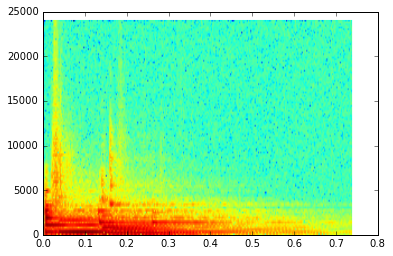

In [41]:
data, freqs, bins, im = specgram(ds, Fs=sample_rate)

### Extracting sine wave components

In [14]:
import os
import scipy
import wave

In [15]:
from sklearn.preprocessing import MaxAbsScaler

In [83]:
compname

'not compressed'

In [125]:
sample_rate, X = wavfile.read("/Descargas/Music_Genres/genres/disco/disco.00000.wav")
ds = X.astype(float)
#X = list(X)
max(X) # Sample seems to be 16-bit

23924

In [127]:
X.shape

(664180L,)

####  Frequency Spectrum - Fast Fourier Transform

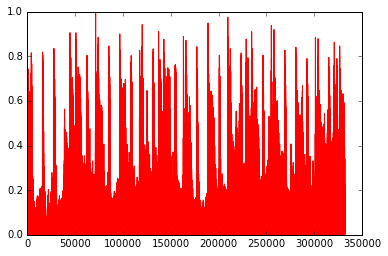

In [142]:
#a = X.T[0] # this is a two channel soundtrack, I get the first track
a = X
a = np.array(a).reshape((len(a), 1)) # Convert into 2D array needed for MaxAbsScaler.
maxabscaler = MaxAbsScaler()
b = maxabscaler.fit_transform(a) # Normalize -1,1
c = fft(b) # calculate fourier transform (complex numbers list)
d = len(c)/2  # you only need half of the fft list (real signal symmetry)
plt.plot(abs(c[:(d-1)]),'r') 
plt.show()

#### Spectogram

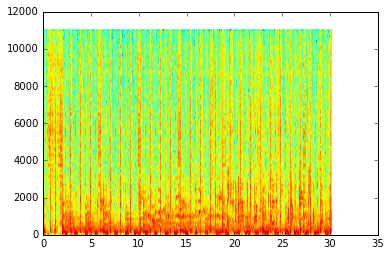

In [67]:
data, freqs, bins, im = specgram(ds, Fs=sample_rate)

The FFT data may be saved in a file to be reused later.<br/>
This is useful to compare different sample files FFT Frequency Spectrum.

In [2]:
def create_fft(fn):
    sample_rate, X = wavfile.read(fn)
    fft_features = abs(scipy.fft(X)[:1000])
    base_fn, ext = os.path.splitext(fn)
    data_fn = base_fn + ".fft"
    scipy.save(data_fn, fft_features)

And to read the <i>fft</i> files:

In [76]:
import glob
def read_fft(genre_list, base_dir=GENRE_DIR):
    X = []
    y = []
    for label, genre in enumerate(genre_list):
        genre_dir = os.path.join(base_dir, genre, "*.fft.npy")
        file_list = glob.glob(genre_dir)
    for fn in file_list:
        fft_features = scipy.load(fn)
        X.append(fft_features[:1000])
        y.append(label)
    return np.array(X), np.array(y)

## The classificator (chap 6) - Introduction

The Bernoulli model of the Naïve Bayes classifier assigns a probability to class C knowing features F1 and F2. Word counts do not matter, only boolean features. P(C|F<sub>1</sub>,F<sub>2</sub>)<br/>
Later on we will implement the multinomial model of the classifier and use word counts instead to calculate probabilities.

### 1. Fitting the problem with Bayesian Probability

Assuming that F<sub>1</sub> and F<sub>2</sub> are independent:


$$P\left (C|F_1,F_2 \right) = \frac {P\left(C\right) \cdot P\left(F_1|C\right) \cdot P\left(F_2|C\right)}{P\left(F_1,F_2 \right)}$$

For instance, to calculate the probability of a theme being either "blues" style or "classical", considering exclusively samples from those two styles:

$$P\left (C="blues"|F_1,F_2 \right) = \frac {P\left(C="blues"\right) \cdot P\left(F_1|C="blues"\right) \cdot P\left(F_2|C="blues"\right)}{P\left(F_1,F_2 \right)}$$

$$P\left (C="classical"|F_1,F_2 \right) = \frac {P\left(C="classical"\right) \cdot P\left(F_1|C="classical"\right) \cdot P\left(F_2|C="classical"\right)}{P\left(F_1,F_2 \right)}$$

We are interested on calculating the <i>argmax</i> of all <i>blues</i> and <i>classical</i> classes of <i>C</i> and keep only the class with the highest <i>P</i> value. We denote that class as <i>c<sub>best</sub></i>, more specifically:

$$
c_{best} = argmax_{c \in C}\; P\left(C=c\right)\cdot
P\left(F_1 |C = c\right) \cdot
P\left(F_2 |C = c\right)
$$

Decomposing the expression into its operands:

$$P\left (C="blues"\right) = \frac{\text{number of blues samples}}{\text{total number of samples}}$$

$$P\left (C="classical"\right) = \frac{\text{number of classical samples}}{\text{total number of samples}}$$

Now let's assume that we have two FFT frequency spectrum types, on is characteristic to <i>blues</i> and the other to <i>classical</i> samples. We call those features <i>F<sub>1</sub></i> and <i>F<sub>2</sub></i> respectively. We want to find out if we can classify random samples comparing their FFT frequency spectrum to the <i>blues</i> and <i>classical</i> samples frequency spectrums. In this case, <i>F<sub>1</sub></i> means that the current sample FFT frequency spectrum is more similar to <i>blues</i>. Conversely, <i>F<sub>2</sub></i> means that the current sample FFT frequency spectrum is more like <i>classical</i> charactersitic FFT frequency spectrum.

In that sense, the next expression would return the probability for any sample of <i>blues</i> class of having its FFT frequency spectrum closer the the <i>blues</i> characteristic spectrum:

$$
P\left(F_1=1 |C = "blues" \right) = \left(\frac{\text{number of blues samples having blues-similar FFT}}{\text{number of total blues samples}}\right)
$$

And, for instance, the next expression would be the number of classical samples having blues-similar FFT:

$$
P\left(F_1=0 |C = "classical" \right) = \left(\frac{\text{number of classical samples having NOT blues FFT}}{\text{number of total blues samples}}\right)
$$

Of course we are not expecting samples having exact matching neither <i>blues</i> nor <i>classical</i> FFT frequency spectrums, but having spectrums that are more similar to one of the two characteristic ones.

The other two probabilities can be deduced from the two previous examples and also we mention that they are the inverse of the another probability:

$$
P\left(F_2=1 |C = "blues" \right) = 1 - P\left(F_1=1 |C = "blues" \right)
$$

$$
P\left(F_2=1 |C = "classical" \right) =  1 - P\left(F_1=1 |C = "classical" \right)
$$

If we want to find the probabilty of two specific values for <i>F<sub>1</sub></i> and <i>F<sub>2</sub></i>, now we have the tools to do it. But first let's see what it means:

<ul>
<li>
<i>F<sub>1</sub></i> = 1, <i>F<sub>2</sub></i> = 0 --> FFT Frequency sample is more like <i>blues</i>
</li>
<li>
<i>F<sub>1</sub></i> = 0, <i>F<sub>2</sub></i> = 1 --> FFT Frequency sample is more like <i>classical</i>
</li>
<li>
<i>F<sub>1</sub></i> = 1, <i>F<sub>2</sub></i> = 1 --> FFT Frequency sample likelihood with <i>blues</i> is the same than for <i>classical</i>
</li>
</ul>

And the formula goes like that:

$$
P\left(F_1,F_2\right)=
P\left(F_1,F_2|C="blues"\right)\cdot
P\left(C="blues"\right)+
P\left(F_1,F_2|C="classical"\right)\cdot
P\left(C="classical"\right)
$$

The possible combinations are:
$$
P\left(F_1 = 1,F_2 = 0\right) \\
P\left(F_1 = 0,F_2 = 1\right) \\
P\left(F_1 = 1,F_2 = 1\right)
$$

Now we finally have all the elelemts required to replace the terms in the two main equations above:

$$P\left (C="blues"|F_1,F_2 \right) = \frac {P\left(C="blues"\right) \cdot P\left(F_1|C="blues"\right) \cdot P\left(F_2|C="blues"\right)}{P\left(F_1,F_2 \right)}$$

$$P\left (C="classical"|F_1,F_2 \right) = \frac {P\left(C="classical"\right) \cdot P\left(F_1|C="classical"\right) \cdot P\left(F_2|C="classical"\right)}{P\left(F_1,F_2 \right)}$$


### 2. Laplace Smoothing

Laplace or additive smoothing are used to adjust the probabilities. We asume that all the possible class values may occur at least once, even if we are not able to find them within our particular sample. This is a more realistic approach.

For this reason, we add 1 to all the occurrences and compensate this increment also adding the number of extra samples added to the denominator of the expressions. For instance if:

$$
P\left(F_1=1|C="classical"\right) = \frac{15}{100} \; \text{ and } P\left(F_1=1|C="blues"\right) = \frac{80}{100}
$$

Then we will smooth it by adding one to each numerator and two to each denominator (because we only add 2 occurrences on the numerators):

$$
P\left(F_1=1|C="classical"\right) = \frac{15+1}{100+2} = \frac{16}{102} 
\; \text{ and } 
P\left(F_1=1|C="blues"\right) = \frac{80+1}{100+2} = \frac{81}{102}
$$




### 3. Tackling Extreme Values

Another important issue treated on the book Building Machine Learning Systems With Python is the extreme value mitigation with logarithmic transformations.

In few words, what it is achieved through logarithmic transformation is to change the scale so that each units corresponds to 10 times the previous unit (for base-10 logarithms). We can apply the logarithm property <i>AXB=LOG(A)+LOG(B)</i> to transform our bayesian equations:

$$
c_{best} = argmax_{c \in C}\; P\left(C=c\right)\cdot
P\left(F_1 |C = c\right) \cdot
P\left(F_2 |C = c\right)
\;
\text{ becomes for any n variables } \\
c_{best} = argmax_{c \in C}\; \left(log P\left(C=c\right) +
log P\left(F_1 |C = c\right) +
log P\left(F_2 |C = c\right) +
\text{...} + 
log P\left(F_n |C = c\right)\right)
$$


## PART II - Spectral Analysis

First, we need to extract the FFT Frequency Spectrum

In [3]:
from os import listdir
from os.path import isfile, join
musicMetalPath = "/Descargas/Music_Genres/genres/metal/"
GENRE_DIR = "/Descargas/Music_Genres/genres/"

In [36]:
# Extracts all the wav files from the folders.
class WavFile:
    wavFileList = []
    wavFileCategory = []
    wavFileFFT = []

def get_fft(fn):
    sample_rate, X = wavfile.read(fn)
    a = X
    a = np.array(a).reshape((len(a), 1)) # Convert into 2D array needed for MaxAbsScaler.
    maxabscaler = MaxAbsScaler()
    b = maxabscaler.fit_transform(a) 
    fft_features = abs(scipy.fft(a))
    fft_features = fft_features[:len(fft_features)/2]
    return fft_features
    
genres = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]
GENRE_DIRS = [join(GENRE_DIR,g + "/") for g in genres]

print "Genres to process: " + str(genres)
for d in GENRE_DIRS:
    current_genre = d.split("/")[-2]
    print "Processing folder " + current_genre
    for f in listdir(d):
        if isfile(join(d, f)):
            fft_feature = get_fft(join(d,f))
            file_name, _ = os.path.splitext(join(d, f))
            file_name = str(file_name).split("/")[-1]
            scipy.save(str(GENRE_DIR) + str("_FFT/") + str(current_genre) + str("_" + file_name + ".fft"), fft_feature)

print "done"

Genres to process: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Processing folder blues
Processing folder classical
Processing folder country
Processing folder disco
Processing folder hiphop
Processing folder jazz
Processing folder metal
Processing folder pop
Processing folder reggae
Processing folder rock


### Analyzing the FFT file

In [393]:
GENRE_DIR

'/Descargas/Music_Genres/genres/'

In [398]:
sample_rate, X = wavfile.read("/Descargas/Music_Genres/genres/disco/disco.00004.wav")

In [40]:
sample_rate

22050

In [399]:
X.shape

(661794L,)

We're going to study the signal in frequencies up to 22050hz<br/>

The wav file contains one channel with 661,794 samples.

The spectrum resolution inc(f) = 100Hz

The number of samples N to collect = f/inc(f) if it was a constant digital signal.

In [400]:
# The total sample length in secons:
len(X)/sample_rate

30

Following the description on Numerical Python, let's study the signal up to frequencies of 30Hz

In [401]:
B = sample_rate-1
f_s = B*2
delta_f = 0.01 #Proportional increment, do not use absolute increment. This is a coefficient.
N = int(f_s/delta_f) ; N
T = N / f_s ; T
print "T:{0} N:{1}".format(N,T)
f_t = X

T:4409800 N:100


In [402]:
max(len(X),N)

4409800

The following code displays the complete signal values in time and a subset of them. 

In [403]:
subplot_time_seconds = 2

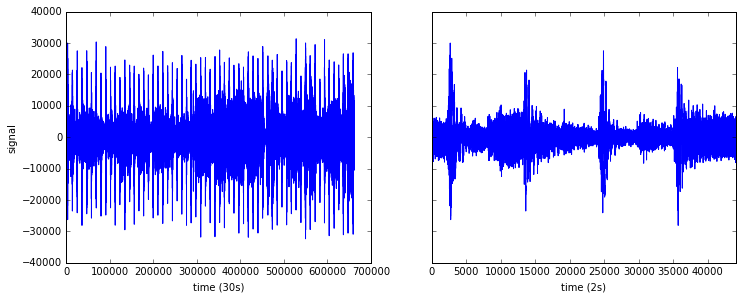

In [404]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)
axes[0].plot(f_t)
axes[0].set_xlabel("time ({0}s)".format(len(f_t)/sample_rate))
axes[0].set_ylabel("signal")
axes[1].plot( f_t)
axes[1].set_xlim(0, subplot_time_seconds*sample_rate)
axes[1].set_xlabel("time ({0}s)".format(subplot_time_seconds))

### Discrete Fourier Transform of the Signal.

(frequency components of the spectrum at frequencies that are given by the sampling rate and number of samples)

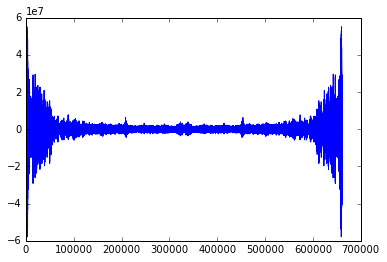

In [241]:
F = fftpack.fft(f_t)
plt.plot(F)

From the chart above it is easy to see that the bins returned are symmetric both horizontally and vertically. For this reason we can just take the positive-frequency components and a number of samples equal to 1/2 the size of the sample file.

Since we are also analyzing different sample files we are going to normalize the F bins between -1 and 1 to compare them.


In [288]:
from sklearn.preprocessing import MaxAbsScaler
maxabscaler = MaxAbsScaler()

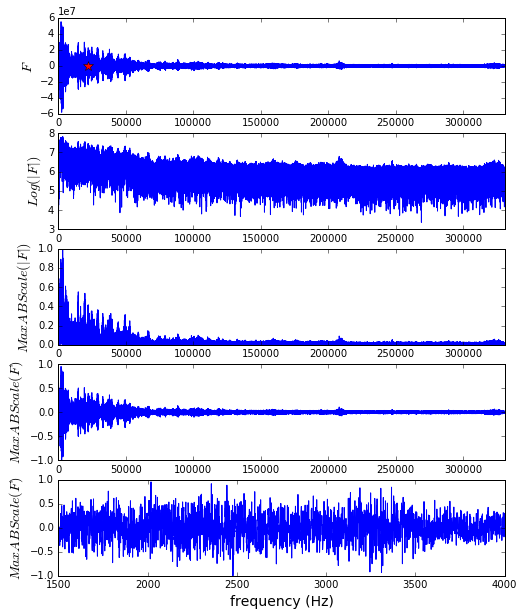

In [481]:
fig, axes = plt.subplots(5, 1, figsize=(8, 10))
axes[0].plot(((F)), label="real")
axes[0].plot(B, 0, 'r*', markersize=10)
axes[0].set_ylabel("$F$", fontsize=14)
axes[0].set_xlim(0, len(F)/2)

axes[1].plot(np.log10(np.abs(F)), label="real")
axes[1].set_xlim(0, len(F)/2)
axes[1].set_ylabel("$Log(|F|)$", fontsize=14)

axes[2].set_xlim(0, int(len(F)/2))
axes[2].plot(maxabscaler.fit_transform(np.array(np.abs(F)).reshape((len(np.abs(F)), 1))), label="real")
axes[2].set_xlabel("frequency (Hz)", fontsize=14)
axes[2].set_ylabel("$MaxABScale (|F|)$", fontsize=14)


axes[3].set_xlim(0, int(len(F)/2))
axes[3].plot(maxabscaler.fit_transform(np.array((F)).reshape((len(np.abs(F)), 1))), label="real")
axes[3].set_xlabel("frequency (Hz)", fontsize=14)
axes[3].set_ylabel("$MaxABScale (F)$", fontsize=14)


axes[4].set_xlim(1.5E3, 4E3)
axes[4].plot(maxabscaler.fit_transform(np.array((F)).reshape((len(np.abs(F)), 1))), label="real")
axes[4].set_xlabel("frequency (Hz)", fontsize=14)
axes[4].set_ylabel("$MaxABScale (F)$", fontsize=14)

^^ Adjust X lables to actual frequency iof sample nbr. ^^

### Windowing Signal

It's a good idea applying any of the windowing functions to the signal so that it approaches its magnitude to zero at the beginning and end of the sampling duration.

It will improve the spectrum contrast before applying the FFT function. Different windowing functions generate slightly different adjustments for slightly different purposes. But overall they are interachangeable.

In [405]:
from scipy import signal
import pandas as pd
from pandas import DataFrame

In [406]:
df = DataFrame(X)
dfTime = DataFrame(range(0,len(X),1),columns=["time"])
dfTime["time"] = dfTime.time.map(lambda x: round(float(x)/float(sample_rate),6))

In [407]:
x = df[0].values.tolist()
time = dfTime.values
window = signal.blackman(len(x))

By multiplying the original signal by the windowed array, we obtain a better contrasted signal sample set.

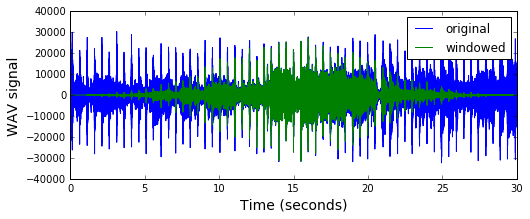

In [408]:
x_windowed = x * window
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(time, x, label="original")
ax.plot(time, x_windowed, label="windowed")
ax.set_ylabel("WAV signal", fontsize=14)
ax.set_xlabel("Time (seconds)", fontsize=14)
ax.set_xlim(0,30)
ax.legend(loc=1)

## Part III - Emotional Wav Analysis

As explained on the book <b>Numerical Python</b> we will apply several <b>DSP techqniques</b> to another wav file. Instead of dance, we will take a country piece and analyze it.

It is a good occassion to digress to explain a bit about <b>musical harmony</b> and introduce a new idea. As an approach we may think that harmony are a set of rules that define the emotion of music. Harmony is composed of scales, arpeggios, chords and how to combine different tones in time and in space to cause a certain emotion to the listener. Waves are just that, variations in time and space in a signal. Because of this parallelism, we can tackle the study of emotions related to the music through the <b>spectral analysis</b> and in general using the Digital Signal Processing techniques.

Arpeggios and <b>chords</b> provide the <b>emotional</b> content to music. Other important emotional components are dynamics in volume and speed. The type of beat can also provide a certain feeling to the music. For instance, major progressions are perceived as positive and minor progressions as sad or even romantic.

For instance, accelerated music may sound comical or emotionally strong, while slow music may be felt as solemn, boring or melancholic.

Through the <b>signal frequencies</b> the different chords and arpeggios can be extracted. And the wave amplitude and signal power with their dynamics may be useful to extract also the other emotional aspects of music.

<b>Occidental instruments</b> are usually tempered upon A4 tone. <b>A4</b> corresponds to <b>440Hz</b> and from that tone, the rest of tones of the musical instruments are then tempered. The lower A3 tone is equivalent to 220Hz and the higher A5 to 880Hz. Tanking this into account we will now focus the wav study on the range between A3 and A5. In order to do this we have to study the <b>spectrum between 220Hz and 880Hz</b> corresponding to all the tones between A3 and A5.

This would provide additional classificators to the model beyond its style.

### Musical Tones and Frequency Spectrum

Each musical tone corresponds to one frequency. We can extract a table with the spectral data we need from Wikipedia to identify each dominant tone 

In [191]:
wiki_frequencies = "https://en.wikipedia.org/wiki/Piano_key_frequencies"
from bs4 import BeautifulSoup
import urllib2

In [192]:
header = {'User-Agent': 'Mozilla/5.0'} #Needed to prevent 403 error on Wikipedia
req = urllib2.Request(wiki_frequencies,headers=header)
page = urllib2.urlopen(req)
soup = BeautifulSoup(page)
table = soup.find("table", { "class" : "wikitable" })

In [193]:
# The first tr contains the field names.
headings = [th.get_text() for th in table.find("tr").find_all("th")]
n=0
datasets = []
for row in table.find_all("tr")[1:]:

    dataset = zip(headings, (td.get_text() for td in row.find_all("td")))
    datasets.append(dataset)

In [243]:
#Create dataframe and assigns better column names
dtTable = pd.DataFrame(datasets,columns=headings).drop(0)
dtTable.columns = ['Key_number', 'Helmholtz_name', 'Scientific_name','Frequency_(Hz)', 'Corresponding_Open_Strings']

#Converts numerical types.
dtTable["Frequency_(Hz)"] = dtTable["Frequency_(Hz)"].map(lambda x: float(x[1]))
dtTable["Key_number"] = dtTable["Key_number"].map(lambda x: int(x[1]))

#Extracts text types and removes Corresponding Open Strings column.
dtTable["Helmholtz_name"] = dtTable["Helmholtz_name"].map(lambda x: x[1])
dtTable["Scientific_name"] = dtTable["Scientific_name"].map(lambda x: x[1])
dtTable = dtTable.drop("Corresponding_Open_Strings", axis=1)

#Sorts table by frequency ascending.
dtTable = dtTable.sort_values("Frequency_(Hz)",ascending=True)

#Converts tone name into index.
dtTable.index = dtTable["Scientific_name"]
dtTable = dtTable.drop("Scientific_name", axis=1)

# And finally we can now select the range between A3 and A5 and the corresponding spectrum 
#(range of frequencies within this signal):
dtTable.loc["A3":"A5"]

,Key_number,Helmholtz_name,Frequency_(Hz)
Scientific_name,,,
A3,37,a,220.000
A♯3/B♭3,38,a♯/b♭,233.082
B3,39,b,246.942
C4 Middle C,40,c′ 1-line octave,261.626
C♯4/D♭4,41,c♯′/d♭′,277.183
D4,42,d′,293.665
D♯4/E♭4,43,d♯′/e♭′,311.127
E4,44,e′,329.628
F4,45,f′,349.228


In [244]:
# And keep a copy of this table for future use.
dtTable.to_json("harmony_table.json")

# To retrieve it use:
# pd.read_json("./harmony_table.json").sort_values("Frequency_(Hz)")

### Signal Spectral Analysis

In [247]:
from scipy import io
GENRE_DIR = '/Descargas/Music_Genres/genres/'
fileName = '/Descargas/Music_Genres/genres/country/country.00053.wav'

In [262]:
sample_rate, data = io.wavfile.read(fileName)
print "Sample rate:{0}, data size:{1}, duration:{2} seconds".format(sample_rate,data.shape,len(data)/sample_rate)

Sample rate:22050, data size:(661794L,), duration:30 seconds


It's a single-channel mono audio file at 22050Hz (22KHz) containing a total of 661,794 samples. As on the book, we first are going to extract a proportion of the file and analize its spectrum. In this case we will extract 10 from the file.

According to the sample rate, each second the signal vibrates 22050 times, this means that each second the wave processes 22050 samples. In order to extract 10 seconds of sound we need to extract a total of 10X22,050 samples, a total of 220,500 samples.

In [263]:
seconds_to_extract = 10
N = seconds_to_extract * sample_rate; N

220500

Since we are also interested on the harmony, we will focus on the area of the spectrum corresponding to frequencies
between A3 and A5.

In [257]:
Lower_freq=200
Upper_freq=900
A3 = 220
A4 = 440
A5 = 880

In [359]:
# f contains the frequency associated to each sample.
f = fftpack.fftfreq(N, 1.0/sample_rate)

In [360]:
#Linspace creates a series but instead of increasing 0.5 in this case, it goes from 0 to 0.5 (the second argument)
#in N times. It create a sequence of N elements equally distant from each other that goes from 0 to 0.5
#We want 3 seconds spread over N samples
t = np.linspace(0, seconds_to_extract, N) ; t

array([  0.00000000e+00,   4.53516796e-05,   9.07033592e-05, ...,
         9.99990930e+00,   9.99995465e+00,   1.00000000e+01])

In [361]:
# We create a mask to filter those samples which frequency range between A3 and A5
mask = (f >= Lower_freq) * (f <= Upper_freq) ; mask

array([False, False, False, ..., False, False, False], dtype=bool)

In [362]:
# Extract the fourier transform data from the sample
subdata = data[:N]
F = fftpack.fft(subdata)

The first chart shows the singal value during the first 3 seconds.
The second chart 

The next two charts display the signal domain and the frequency domain respectively.

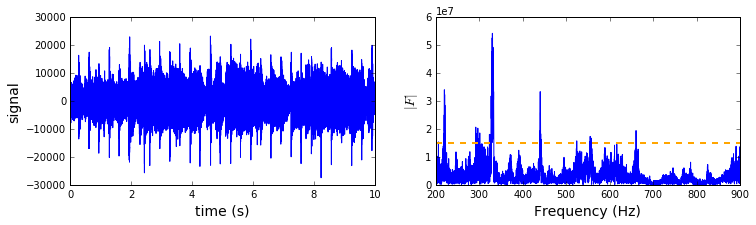

In [363]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(t, subdata)
axes[0].set_ylabel("signal", fontsize=14)
axes[0].set_xlabel("time (s)", fontsize=14)
axes[1].plot(f[mask], abs(F[mask])) # The f[mask] contains only those points of the frequency (0,2000+) filtered.
axes[1].set_xlim(Lower_freq, Upper_freq)
axes[1].set_ylabel("$|F|$", fontsize=14)
axes[1].set_xlabel("Frequency (Hz)", fontsize=14)
axes[1].axhline(y=1.5E7,color="orange", linestyle="dashed",lw="2")

From the frequency spectrum graph, we can now highlight the more frequent frequencies:

In [373]:
fmask = f[mask]
Fmask = F[mask]

newmask = Fmask>=1E7
fmask = fmask[newmask]
Fmask = Fmask[newmask]

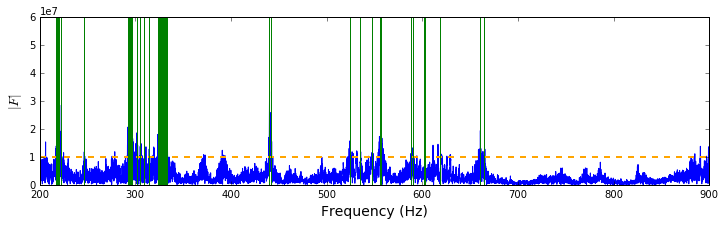

In [385]:
fig, axes = plt.subplots(1, 1, figsize=(12, 3))
axes.plot(f[mask], abs(F[mask])) # The f[mask] contains only those points of the frequency (0,2000+) filtered.
axes.set_xlim(Lower_freq, Upper_freq)
axes.set_ylabel("$|F|$", fontsize=14)
axes.set_xlabel("Frequency (Hz)", fontsize=14)
axes.axhline(y=1E7,color="orange", linestyle="dashed",lw="2")

frequencyList = np.unique([int(x) for x in np.array(fmask)]).tolist() ; frequencyList

for p in frequencyList:
    axes.axvline(p, color="green",lw=1)
    fig.canvas.draw()

Now the resulting frequency list could fine-tuned to define it as a range instead of discrete points and gather more information from the frequency. We however won't do it now.

Now we are going to extract the dominant tones on the sample file.

In [390]:
dtTable["Frequency_int"] = dtTable["Frequency_(Hz)"].map(lambda x: int(x))
dtTable[dtTable.Frequency_int.isin(frequencyList)]

,Key_number,Helmholtz_name,Frequency_(Hz),Frequency_int
Scientific_name,,,,
A3,37,a,220.000,220
B3,39,b,246.942,246
E4,44,e′,329.628,329
A4 A440,49,a′,440.000,440


The combination is interesting. It corresponds to chord <b>ASus2</b>. It is a chord which major 3rd (B#) is replaced by the 2nd (B), resulting in a chord that has not neither major nor minor key.

To hear how it sounds, please <a href="http://www.scales-chords.com/chord-sounds/snd-piano-chord-Asus2.mp3">Click here</a> and to hear how suspended 2nd chords sound in contrast to other chords, <a href="http://music.tutsplus.com/articles/adding-flavor-to-chords-suspended-chords-basix--audio-12823">click here</a>.

Being this the dominant chord, many variations may be developed from it. Click on this <a href="http://www.scales-chords.com/findnotes_en.php?n1=&n2=&n3=&n4=A&n5=B&n6=E">link</a> to examine the different chords that can be composed using tones A, B and E.

Finally, to download the wav file and listen the actual music <a href="https://1drv.ms/u/s!AgossqyQVK7mgdZoogjNToEQXgG4gQ">click here</a>.

But, <b>what does A, B, and E emotionally mean?</b>

Suspended 2nd chords are neutral. The music is about to resolve in a new chord. We could therefore infer that the first 10 seconds of this piece of music are basically preparing the listener for a musical resolution, waiting for what's about to happen, holding on.